In [1]:
import pandas as pd
import numpy as np 
import ast
from sklearn import *
import tensorflow as tf
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
import math
import feather
from surprise.model_selection import cross_validate
import itertools


In [2]:
# Read data
artists = pd.read_csv('./Data-20220222/Data Group Assignment/Artists.dat', sep='\t', header='infer')
tags = pd.read_csv('./Data-20220222/Data Group Assignment/tags.dat', sep='\t', header='infer', encoding = 'unicode_escape', engine ='python')
user_artists = pd.read_csv('./Data-20220222/Data Group Assignment/user_artists.dat', sep='\t', header='infer', encoding = 'unicode_escape', engine ='python')
user_taggedartists = pd.read_csv('./Data-20220222/Data Group Assignment/user_taggedartists.dat', sep='\t', header='infer', encoding = 'unicode_escape', engine ='python')

# Preprocessing the Data en ensuring both tables have the same Items and UsersIDs

In [3]:
# remove duplicated from userID list for then using it 
userID_colab_filt_df =  user_artists.userID
userID_colab_filt_df= list(set(userID_colab_filt_df))
len(userID_colab_filt_df)

1892

In [4]:
# remove duplicated from userID list for then using it 
content_df = pd.merge(user_taggedartists, tags, how='left', on="tagID")
content_df_userID =  content_df.userID
content_df_userID= list(set(content_df_userID))
len(content_df_userID)

1892

In [5]:
# same UserIDs for both cases. 
print(content_df_userID==userID_colab_filt_df)

True


In [6]:
# now we check the same for ArtistIDs:
colab_filt_df_artistID =  user_artists.artistID
colab_filt_df_artistID= list(set(colab_filt_df_artistID))
len(colab_filt_df_artistID)
# different result from the other dataframe, content_df_artistID.

17632

In [7]:
# we check the same for ArtistIDs:
content_df_artistID =  user_taggedartists.artistID
content_df_artistID= list(set(content_df_artistID))
len(content_df_artistID)

12523

In [8]:
# Not the same ArtistIDs, we need to filter...
print(content_df_artistID==colab_filt_df_artistID)

False


In [9]:
# Matches of ArtistIDs
matches_artistID =list(set(content_df_artistID).intersection(set(colab_filt_df_artistID)))
len(matches_artistID)

12133

In [10]:
# filtering dataframe with matched list for artistID
colab_filt_df_filtered = user_artists[user_artists['artistID'].isin(matches_artistID)]
# filtering dataframe with matched list for artistID
content_df_filtered = content_df[content_df['artistID'].isin(matches_artistID)]

In [11]:
colab_filt_df_filtered.head(2)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690


In [12]:
colab_filt_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86608 entries, 0 to 92827
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    86608 non-null  int64
 1   artistID  86608 non-null  int64
 2   weight    86608 non-null  int64
dtypes: int64(3)
memory usage: 2.6 MB


In [13]:
content_df_filtered.head(2)

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo


In [14]:
content_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184941 entries, 0 to 186478
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userID    184941 non-null  int64 
 1   artistID  184941 non-null  int64 
 2   tagID     184941 non-null  int64 
 3   day       184941 non-null  int64 
 4   month     184941 non-null  int64 
 5   year      184941 non-null  int64 
 6   tagValue  184941 non-null  object
dtypes: int64(6), object(1)
memory usage: 11.3+ MB


In [15]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [16]:
artists_df = artists
artists_df['artistID']=artists['id']
artists_df.head()

,id,name,url,pictureURL,artistID
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,1
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,2
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,3
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,4
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,5


In [17]:
artists_df = artists_df[['artistID','name','url','pictureURL']]
artists_df.head()

,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [18]:
first = pd.merge(colab_filt_df_filtered, artists_df, how='inner', on="artistID")
first.head()

,userID,artistID,weight,name,url,pictureURL
0,2,51,13883,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,4,51,228,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
2,27,51,85,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
3,28,51,10,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
4,62,51,528,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg


In [19]:
first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86608 entries, 0 to 86607
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userID      86608 non-null  int64 
 1   artistID    86608 non-null  int64 
 2   weight      86608 non-null  int64 
 3   name        86608 non-null  object
 4   url         86608 non-null  object
 5   pictureURL  86579 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.6+ MB


In [20]:
#full = pd.merge(first, colab_filt_df_filtered, how='inner', on=['userID','artistID'])

In [21]:
#full.head()

In [22]:
#full.info()

In [23]:
# we will use this later
lookup_asin = first.drop_duplicates(subset=["artistID"], keep="last").set_index("artistID")

# collaborative filtering 

In [24]:
colab_filt_df_filtered.shape
# 92834 relationships in total and 3 columns 

(86608, 3)

In [25]:
colab_filt_df_filtered.info()
# all 3 columns are integers and there are no missing values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86608 entries, 0 to 92827
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    86608 non-null  int64
 1   artistID  86608 non-null  int64
 2   weight    86608 non-null  int64
dtypes: int64(3)
memory usage: 2.6 MB


In [26]:
colab_filt_df_filtered.duplicated(subset=['userID', 'artistID','weight'], keep='first').sum()
# there are no duplicates in this dataset

0

In [27]:
colab_filt_df_filtered

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92820,2100,8533,724
92821,2100,9783,793
92823,2100,10894,705
92826,2100,13978,535


In [28]:
colab_filt_df_filtered.describe()

,userID,artistID,weight
count,86608.000000,86608.000000,86608.000000
mean,1036.038438,2808.731965,775.986225
std,610.648902,3844.022552,3877.502052
min,2.000000,1.000000,1.000000
25%,501.000000,405.000000,113.000000
50%,1027.000000,1098.000000,271.000000
75%,1566.000000,3444.000000,637.000000
max,2100.000000,18744.000000,352698.000000


In [29]:
# in the project description it says that we have to watch out, because the weights column is continuous and skewed
# solution = categorize the data 

<AxesSubplot:>

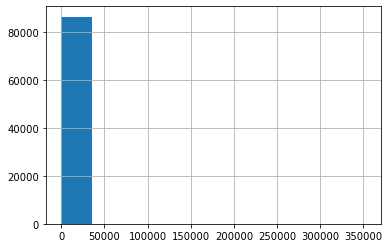

In [30]:
colab_filt_df_filtered.weight.hist()
# the weight column is not nicely distributed

In [31]:
# I will add a column ratings (from 1 to 5)
colab_filt_df_filtered['ratings'] = 0
colab_filt_df_filtered.loc[colab_filt_df_filtered['weight'] <= colab_filt_df_filtered['weight'].quantile(1), 'ratings'] = 5
colab_filt_df_filtered.loc[colab_filt_df_filtered['weight'] < colab_filt_df_filtered['weight'].quantile(0.8), 'ratings'] = 4
colab_filt_df_filtered.loc[colab_filt_df_filtered['weight'] < colab_filt_df_filtered['weight'].quantile(0.6), 'ratings'] = 3
colab_filt_df_filtered.loc[user_artists['weight'] < colab_filt_df_filtered['weight'].quantile(0.4), 'ratings'] = 2
colab_filt_df_filtered.loc[user_artists['weight'] < colab_filt_df_filtered['weight'].quantile(0.2), 'ratings'] = 1

C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\2481473721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colab_filt_df_filtered['ratings'] = 0


<AxesSubplot:>

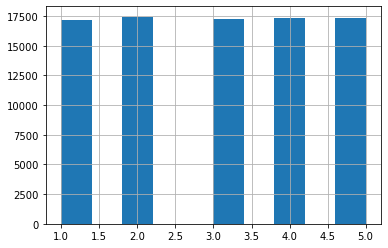

In [32]:
colab_filt_df_filtered.ratings.hist(bins=10)
# the ratings column is nicely distributed

In [33]:
# Delete the weight column because we don't need it 
colab_filt_df_filtered = colab_filt_df_filtered[['userID','artistID','ratings']]

In [34]:
colab_filt_df_filtered

,userID,artistID,ratings
0,2,51,5
1,2,52,5
2,2,53,5
3,2,54,5
4,2,55,5
...,...,...,...
92820,2100,8533,4
92821,2100,9783,5
92823,2100,10894,4
92826,2100,13978,4


In [35]:
# Import user-rating matrix
data = colab_filt_df_filtered[['userID', 'artistID', 'ratings']]

# train-test split
train, test = train_test_split(data, test_size=0.3, random_state=42)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(data.shape)
print(train.shape)
print(test.shape)

print('------ Train ------')
print('Nr items:', len(train["artistID"].unique()))
print('Nr users:', len(train["userID"].unique()))

print('\n------ Test ------')
print('Nr items:', len(test["artistID"].unique()))
print('Nr users:', len(test["userID"].unique()))

print('\nNr new items:', len(set(test["artistID"])-set(train["artistID"])))
print('Nr new users:', len(set(test["userID"])-set(train["userID"])))

(86608, 3)
(60625, 3)
(25983, 3)
------ Train ------
Nr items: 10249
Nr users: 1887

------ Test ------
Nr items: 6438
Nr users: 1886

Nr new items: 1884
Nr new users: 5


In [36]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1, 5))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

# User-based CF

In [37]:
# # cross validation to find the best parameters 

# from surprise.model_selection import GridSearchCV

# df_auto = Dataset.load_from_df(train, reader)

# param_grid = {'k': [5, 15, 30],
#               'min_k': [2, 5, 10],
#               'sim_options': {'name': ['pearson', 'cosine'],
#                               'user_based': [True]}
#               }

# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(df_auto)

# # combination of parameters with the best RMSE
# print(gs.best_params['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Compu

In [38]:
from surprise import KNNBasic

# set option to cosine similarity and user-based collaborative filtering
options = {'name':'pearson', 'user_based':True}

# select 30 most similar users (min 10)
ub = KNNBasic(k=30, min_k=10, sim_options=options, random_state=42)

# fit on training set
ub.fit(df_train)

# predict
ub_pred = ub.test(df_test)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [39]:
# evaluate
ub_res = eval.evaluate(ub_pred, topn=5, rating_cutoff=4).rename(columns={'value':'User_based'})
ub_res

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,User_based
RMSE,1.402997
MAE,1.195240
Recall,0.021876
Precision,0.673529
F1,0.042376
NDCG@5,0.890630


# Item-based CF

In [40]:
# # cross validation to find the best parameters 

# from surprise.model_selection import GridSearchCV

# df_auto = Dataset.load_from_df(train, reader)

# param_grid = {'k': [5, 15, 30],
#               'min_k': [2, 5, 10],
#               'sim_options': {'name': ['pearson', 'cosine'],
#                               'user_based': [False]}
#               }

# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(df_auto)

# # combination of parameters with the best RMSE
# print(gs.best_params['rmse'])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Compu

In [41]:
# set option to cosine and item-based collaborative filtering
options = {'name':'cosine', 'user_based':False}

# select 15 most similar items (min 2)
ib = KNNBasic(k=15, min_k=2, sim_options=options, random_state=42)

# fit on training set
ib.fit(df_train)

# predict
ib_pred = ib.test(df_test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
# evaluate
ib_res = eval.evaluate(ib_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Item_based'})
ib_res

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,Item_based
RMSE,1.018119
MAE,0.778369
Recall,0.488632
Precision,0.867537
F1,0.625153
NDCG@5,0.844591


# Matrix Factorization

In [43]:
# # cross validation to find the best parameters 

# from surprise.model_selection import GridSearchCV

# df_auto = Dataset.load_from_df(train, reader)

# param_grid = {'n_factors': [5, 10, 20], 'n_epochs':[10, 20]}

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(df_auto)

# # combination of parameters with the best RMSE
# print(gs.best_params['rmse'])

{'n_factors': 5, 'n_epochs': 20}


In [116]:
from surprise import SVD

# select 5 factors and 20 n_epochs
mf = SVD(random_state=10)

# fit on training set
mf.fit(df_train)

# predict
mf_pred = mf.test(df_test)

In [110]:
mf_res = eval.evaluate(mf_pred, topn=5, rating_cutoff=4).rename(columns={'value':'SVD'})
mf_res

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,SVD
RMSE,0.881286
MAE,0.695112
Recall,0.459782
Precision,0.928971
F1,0.615119
NDCG@5,0.850307


# Cluster-based CF

In [47]:
# # cross validation to find the best parameters 

# from surprise.model_selection import GridSearchCV
# from surprise import CoClustering

# df_auto = Dataset.load_from_df(train, reader)

# param_grid = {'n_cltr_u': [5, 10, 20],'n_cltr_i': [5, 10, 20]}

# gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(df_auto)

# # combination of parameters with the best RMSE
# print(gs.best_params['rmse'])

{'n_cltr_u': 5, 'n_cltr_i': 5}


In [48]:
# select 10 user-based and 5 item based clusters
clust = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=50, random_state=42)

# fit on training set
clust.fit(df_train)

# predict
clust_pred = clust.test(df_test)

C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\2490154755.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clust.fit(df_train)


In [49]:
clust_res = eval.evaluate(clust_pred, topn=5, rating_cutoff=4).rename(columns={'value':'CoClust'})
clust_res

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,CoClust
RMSE,1.014835
MAE,0.773442
Recall,0.495606
Precision,0.846053
F1,0.625060
NDCG@5,0.854472


In [112]:
overview = pd.concat([ub_res, ib_res, mf_res, clust_res], axis=1)
overview

,User_based,Item_based,SVD,CoClust
RMSE,1.402997,1.018119,0.881286,1.014835
MAE,1.195240,0.778369,0.695112,0.773442
Recall,0.021876,0.488632,0.459782,0.495606
Precision,0.673529,0.867537,0.928971,0.846053
F1,0.042376,0.625153,0.615119,0.625060
NDCG@5,0.890630,0.844591,0.850307,0.854472


## content-based model

In [52]:
print(user_taggedartists.head(2))
print(user_taggedartists.shape)

   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
(186479, 6)


In [53]:
print(tags.head(2))
print(user_taggedartists.shape)

   tagID           tagValue
0      1              metal
1      2  alternative metal
(186479, 6)


In [54]:
content_df.year.max()
content_df.year.min()

1956

<AxesSubplot:>

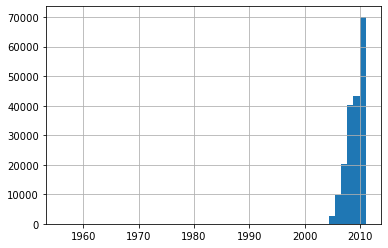

In [55]:
content_df['year'].hist(bins=50)

In [56]:
content_df

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists
...,...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010,black metal
186475,2100,16437,292,1,5,2010,folk
186476,2100,16437,2087,1,7,2010,depressive black metal
186477,2100,16437,2801,1,5,2010,dark folk


In [57]:
# same users and same artistID  
content_df.userID.value_counts()

1672    2609
1380    2075
1249    2024
1929    1876
1832    1863
        ... 
303        1
1949       1
841        1
838        1
1397       1
Name: userID, Length: 1892, dtype: int64

In [59]:
content_cross_table = pd.crosstab(content_df_filtered['artistID'], content_df_filtered['tagValue'])

In [60]:
content_df_filtered

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists
...,...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010,black metal
186475,2100,16437,292,1,5,2010,folk
186476,2100,16437,2087,1,7,2010,depressive black metal
186477,2100,16437,2801,1,5,2010,dark folk


In [61]:
content_cross_table[content_cross_table.index==16437].sum(axis=1) 

artistID
16437    6
dtype: int64

In [62]:
content_cross_table

tagValue,'80s,-pearl fashion music,0 play yet,00,00's,007,00s,00s rock,1,1008,...,zikirli,zmiel pierogi,zmierzch,zombie,zombie rave,zombieland,zoocore,zornish,ztt,zu
artistID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
from sklearn.metrics.pairwise import cosine_similarity
import surprise

# Content Based as a Class
class ContentBased:

    def __init__(self, NN):
        self.NN = NN
        self.fitted = {"content":False, "ratings":False}
        
    def fit(self, content_data):

        self.items = content_data.index.values
        self.item_dim = len(self.items)
        # check for duplicate items
        assert (len(self.items) == len(set(self.items))), "Duplicate items in content data!"

        # compute similarity
        self.matrix = cosine_similarity(content_data.values)
        np.fill_diagonal(self.matrix, 0)
        
        self.matrixNN = self.matrix.copy()

        # filter similarity matrix for NN nearest neighbors (constraint: non-negative similarity)
        for i in range(self.item_dim):
            crit_val = max(-np.sort(-self.matrix[i])[self.NN-1], 0)
            self.matrixNN[i][self.matrixNN[i] < crit_val] = 0.0
        
        self.fitted["content"] = True

    # helper -> transform surprise.trainset.Trainset to pd.DataFrame
    def _trainset2list(self, trainset):
        return pd.DataFrame([(trainset.to_raw_uid(u), trainset.to_raw_iid(i), r) for (u, i, r) in trainset.all_ratings()], columns=["user", "item", "rating"])

    def fit_ratings(self, df):

        if not self.fitted["content"]:
            raise Exception("Fit model on content data!")

        if isinstance(df, surprise.trainset.Trainset):
            df = self._trainset2list(df)
        
        # fix unknown items
        unknown_items = list(set(df["item"]) - set(self.items))
        if len(unknown_items) > 0:
            print(f"Warning {len(unknown_items)} items are not included in content data: {unknown_items}")
        df = df[df["item"].isin(self.items)].reset_index(drop=True)

        # store user data
        self.users = np.unique(df["user"])
        self.user_dim = len(self.users)

        # fix missing items
        missing_items = list(set(self.items) - set(df["item"]))
        if len(missing_items) > 0: 
            fix_df = pd.DataFrame([{"user":np.nan, "item":i, "rating":np.nan} for i in missing_items])
            df = df.append(fix_df).reset_index(drop=True)

        # pivot 
        df_pivot = df.pivot_table(index='user', values='rating', columns='item', dropna=False).reindex(self.users)

        # row-wise (user) average
        self.user_avg = np.array(np.mean(df_pivot, axis=1))
        self.global_mean = np.mean(self.user_avg)

        # center ratings
        df_pivot = df_pivot.sub(self.user_avg, axis=0).fillna(0)

        # predict ratings for each item 
        denom = self.matrixNN.sum(axis=0) # column sums
        self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]

        # replace NA values with mean
        # prediction[np.isnan(prediction)] = self.global_mean

        self.fitted["ratings"] = True
    
    # get predicted value for user-item combination
    def predict(self, user, item, r_ui=None):
        details = {"was_impossible":False}

        # check whether user and item are unknown -> default = global average rating
        if self.knows_user(user) & self.knows_item(item):

            # convert user & item in internal ids
            iid = np.where(self.items == item)[0].item()
            uid = np.where(self.users == user)[0].item()

            # inference prediction
            est = self.prediction[uid, iid]
            
            if np.isnan(est): 
                est = self.global_mean
                details["was_impossible"] = True
            return surprise.Prediction(user, item, r_ui, est, details)
        
        else:
            details["was_impossible"] = True
            details["reason"] = "User or item unknown"
            return surprise.Prediction(user, item, r_ui, self.global_mean, details)

    # predict entire testset
    def test(self, testset):
        if not self.fitted["ratings"]:
            raise Exception("Fit model on ratings data!")
        return [self.predict(user=u,item=i,r_ui=r) for (u,i,r) in testset]

    def knows_user(self, user):
        return user in self.users   

    def knows_item(self, item):
        return item in self.items        

    # get topn most similar items 
    def get_most_similar(self, item, topn=5):

        # get iid
        if self.knows_item(item):
            iid = np.where(self.items == item)[0].item()
        else:
            raise Exception(f"Item {item} unknown ...")
        
        list_iids = (-self.matrix[iid]).argsort()[:topn]
        return self.items[list_iids]

    def get_similarities(self):
        print('Cosine similarities shape: ({}, {}) items x items'.format(self.item_dim, self.item_dim))
        return self.matrix

In [64]:
# init content-based
cb = ContentBased(NN=10)

# fit on content
cb.fit(content_cross_table)

# fit on train_ratings
cb.fit_ratings(df_train)

# predict test ratings
cb_pred = cb.test(df_test)

C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\2647039970.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(fix_df).reset_index(drop=True)
C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\2647039970.py:71: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [65]:
# compute metrics
cb_res = eval.evaluate(cb_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based'})
cb_res

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,Content_based
RMSE,0.901403
MAE,0.683674
Recall,0.502484
Precision,0.915260
F1,0.648782
NDCG@5,0.876994


In [113]:
overview = pd.concat([overview, cb_res], axis=1)
overview

,User_based,Item_based,SVD,CoClust,Content_based
RMSE,1.402997,1.018119,0.881286,1.014835,0.901403
MAE,1.195240,0.778369,0.695112,0.773442,0.683674
Recall,0.021876,0.488632,0.459782,0.495606,0.502484
Precision,0.673529,0.867537,0.928971,0.846053,0.915260
F1,0.042376,0.625153,0.615119,0.625060,0.648782
NDCG@5,0.890630,0.844591,0.850307,0.854472,0.876994


# 3 Hybrid Models

# Hybrid Model 1: Hybrid_UserBased_ItemBased

In [67]:
# Combine predictions (mean)

# extract predictions content-based and item-based
df_pred_cb, df_pred_ib = pd.DataFrame(cb_pred), pd.DataFrame(ib_pred)

In [68]:
df_hybrid = df_pred_cb.copy()

In [69]:
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_ib['est'])) / 2
df_hybrid.head()

,uid,iid,r_ui,est,details
0,1373,2176,3,3.689235,{'was_impossible': False}
1,186,693,4,1.747678,{'was_impossible': False}
2,59,707,5,4.489464,{'was_impossible': False}
3,64,1831,3,2.876031,{'was_impossible': False}
4,1904,205,5,3.019864,{'was_impossible': False}


In [70]:
hb_cbib = eval.evaluate(df_hybrid, topn=5, rating_cutoff=5).rename(columns={'value':'Hybrid_UserBased_ItemBased'})
hb_cbib

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))


,Hybrid_UserBased_ItemBased
RMSE,0.926046
MAE,0.720409
Recall,0.124492
Precision,1.000000
F1,0.221419
NDCG@5,0.846437


# Hybrid Model 2: Hybrid_LinearRegression

In [71]:
# linear regression model

In [72]:
# training set for Linear Regression model
lr_train = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.head()

,target,ib_pred,cb_pred
0,3,3.688815,3.689655
1,4,1.592130,1.903226
2,5,4.464643,4.514286
3,3,3.002062,2.750000
4,5,3.104243,2.935484


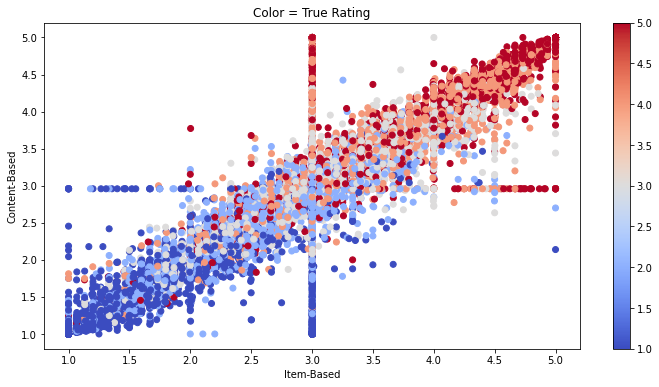

In [73]:
# visualize
scatter_df = lr_train.sample(10000, random_state=42)
plt.figure(figsize = (12, 6))
plt.scatter(x=scatter_df.ib_pred, y=scatter_df.cb_pred, c=scatter_df.target, cmap='coolwarm')
plt.xlabel('Item-Based')
plt.ylabel('Content-Based')
plt.title('Color = True Rating')
plt.colorbar()

In [74]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [75]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_pred_ib[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'ib_pred'})
lr_test['cb_pred'] = df_pred_cb['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_pred_ib.copy()
df_lr['est'] = lr_pred

In [76]:
hb_lr = eval.evaluate(df_lr, topn=5, rating_cutoff=5).rename(columns={'value':'Hybrid_LinearRegression'})
hb_lr

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:147: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impo

,Hybrid_LinearRegression
RMSE,0.899999
MAE,0.687696
Recall,0.000000
Precision,NaN
F1,NaN
NDCG@5,0.853149


# Hybrid Model 3: Random Forest

In [ ]:
# random forest hybrid

In [77]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

,target,ib_pred,cb_pred
0,3,3.688815,3.689655
1,4,1.592130,1.903226
2,5,4.464643,4.514286
3,3,3.002062,2.750000
4,5,3.104243,2.935484


In [78]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [79]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_ib.copy()
df_rf['est'] = rf_pred

In [80]:
# Evaluate
hb_rf = eval.evaluate(df_rf, topn=5, rating_cutoff=5).rename(columns={'value':'Hybrid_RandomForest'})
hb_rf

C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:147: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impossible)).append(ranking_metrics(prediction, topn, excl_impossible=excl_impossible))
C:\Users\mcortez\Desktop\RECOMMENDATION TOOLS\GROUP Project\IESEGRecSys\eval.py:245: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return prediction_metrics(prediction, excl_impossible=excl_impossible).append(classification_metrics(prediction, rating_cutoff, excl_impossible=excl_impo

,Hybrid_RandomForest
RMSE,0.892121
MAE,0.684397
Recall,0.000000
Precision,NaN
F1,NaN
NDCG@5,0.879257


In [114]:
overview = pd.concat([overview, hb_cbib, hb_lr, hb_rf], axis=1)
overview

,User_based,Item_based,SVD,CoClust,Content_based,Hybrid_UserBased_ItemBased,Hybrid_LinearRegression,Hybrid_RandomForest
RMSE,1.402997,1.018119,0.881286,1.014835,0.901403,0.926046,0.899999,0.892121
MAE,1.195240,0.778369,0.695112,0.773442,0.683674,0.720409,0.687696,0.684397
Recall,0.021876,0.488632,0.459782,0.495606,0.502484,0.124492,0.000000,0.000000
Precision,0.673529,0.867537,0.928971,0.846053,0.915260,1.000000,NaN,NaN
F1,0.042376,0.625153,0.615119,0.625060,0.648782,0.221419,NaN,NaN
NDCG@5,0.890630,0.844591,0.850307,0.854472,0.876994,0.846437,0.853149,0.879257


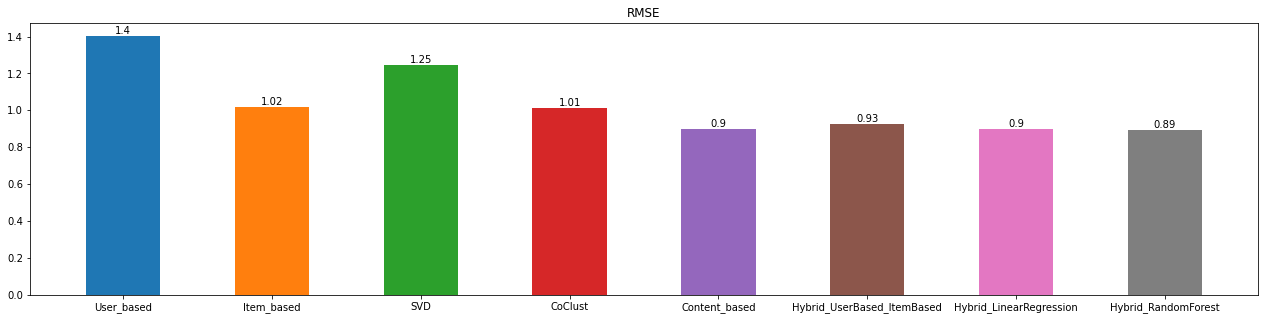

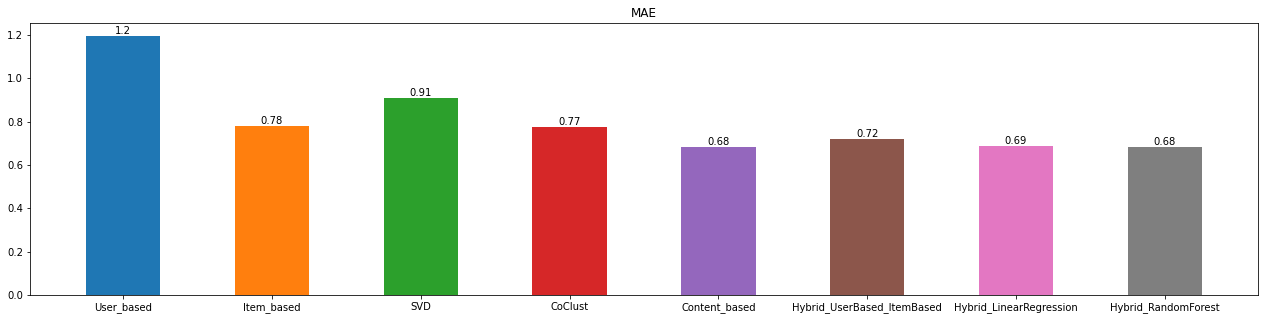

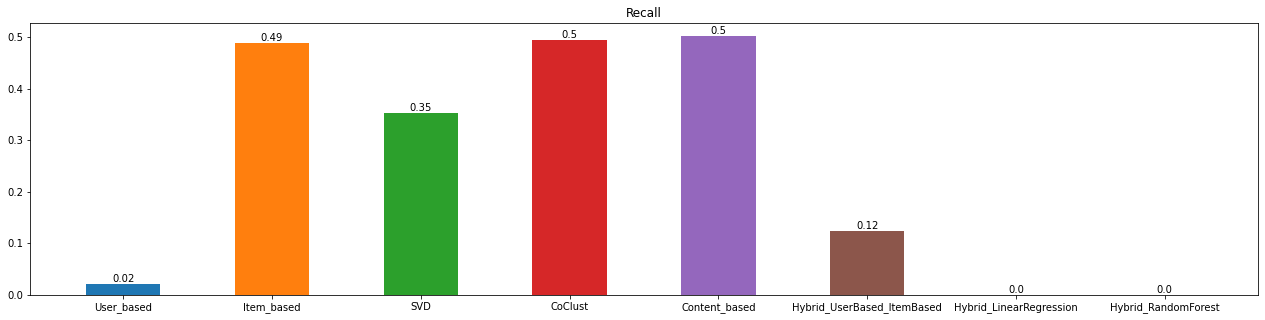

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


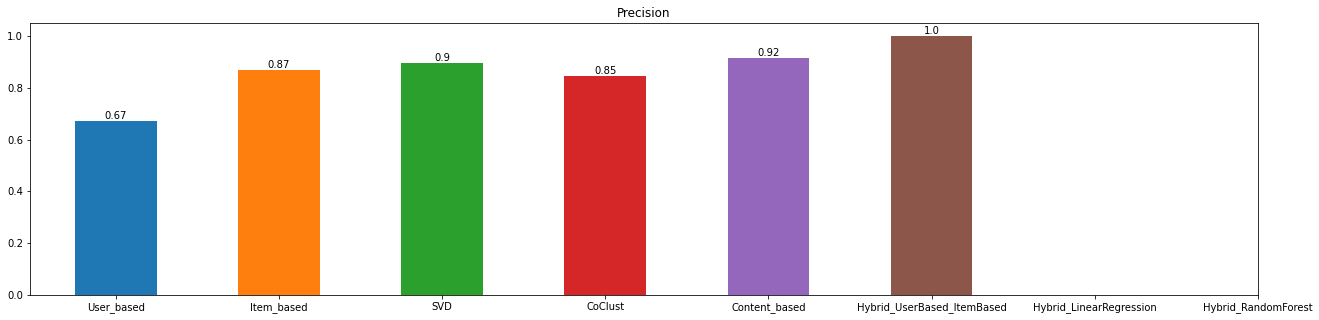

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


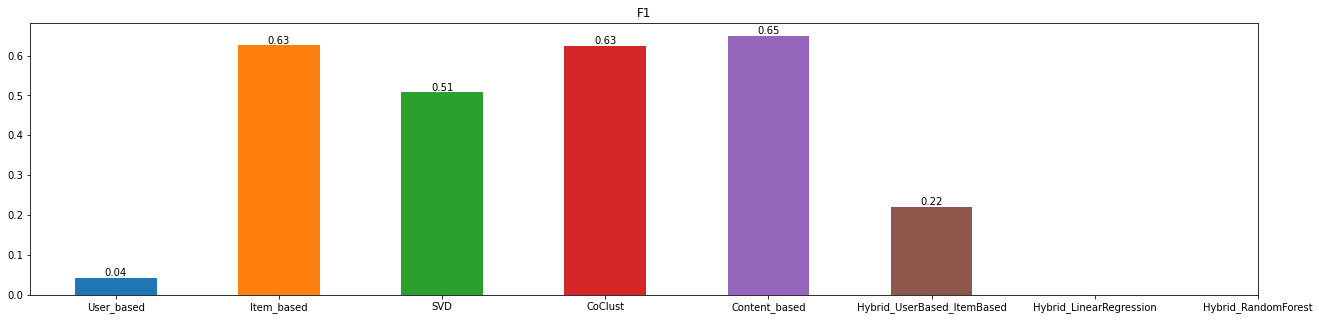

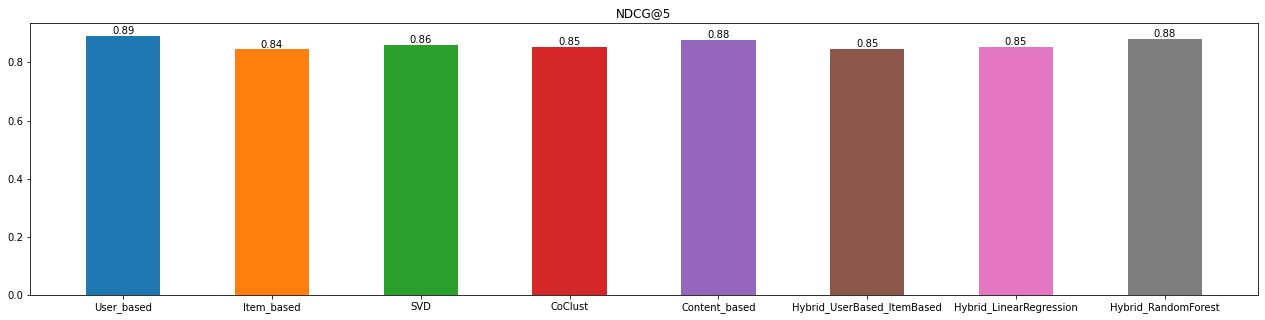

In [89]:
# simple visualization (Bar Chart)

import matplotlib.pyplot as plt

width = .5

for j, row in enumerate(overview.index):
    fig, ax = plt.subplots(figsize=(22,5))
    x = np.arange(len(overview.columns))
    for i, col in enumerate(overview.columns):
        plt.bar(x[i], overview.iloc[j,i], width, label='col')
        ax.text(x[i], overview.iloc[j,i], str(round(overview.iloc[j,i],2)),
                ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_title(row)
    ax.set_xticklabels(overview.columns)
    plt.show()

# Qualitative recommendations for a specific user

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60625 entries, 0 to 60624
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    60625 non-null  int64
 1   artistID  60625 non-null  int64
 2   ratings   60625 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [91]:
train.head()

,userID,artistID,ratings
0,1690,16061,3
1,322,3317,5
2,1388,5180,1
3,1904,16068,2
4,1781,6400,2


In [92]:
def predict_user_topn(model, train, user, topk=15, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

In [93]:
# Top 3 recommendations for user 322

user = 322
topk = 10

res = {}
for model_name, model in dict(user_based=ub, item_based=ib, svd=mf, coclustering=clust).items():
    pred = predict_user_topn(model, train, user=user, topk=topk, item_col="artistID")

    # get name for each of the predicted product ids
    pred_name = [lookup_asin.loc[i]["name"] for i in pred]

    res[model_name] = pred_name

pd.DataFrame(res)

,user_based,item_based,svd,coclustering
0,Rihanna,Moi dix Mois,Dulce María,DJ Risk One
1,Beyoncé,Lewis Black,Britney Spears,Fyfe Dangerfield
2,Black Eyed Peas,Texas in July,Selena Gomez & the Scene,Eagles of Death Metal
3,Ke$ha,Panda,浜崎あゆみ,陳奕迅
4,Nicki Minaj,The String Quartet,Taylor Swift,Jesse Cook
5,Lily Allen,The Fire Restart,Akira Yamaoka,Ibrahim Ferrer
6,Lady Gaga,Empyrium,Ke$ha,莫文蔚
7,Eminem,平沢進,Miley Cyrus,盧巧音
8,RBD,A Plea for Purging,Christina Aguilera,王菲
9,The Saturdays,Betraying The Martyrs,Katy Perry,Do or Die


# Encouraging Variety 

In [8]:
# From: https://sundog-education.com/course/building-recommender-systems-with-machine-learning-and-ai/
# using export1.csv, diversitymetrics.csv, MovieLens.py, RecommenderMetrics.py and TestMetrics.py

In [101]:
# packages we will use, leave them here because if you run it on the first line with the rest surprise will replace train_test_split
from MovieLens import MovieLens
from surprise import SVD
from surprise import KNNBaseline
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from RecommenderMetrics import RecommenderMetrics

In [194]:
ml = MovieLens()

print("Loading ratings...")
base = pd.read_csv('./Data-20220222/Data Group Assignment/export1.csv')
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(base, reader)

print("\nComputing popularity ranks so we can measure novelty later...")
rankings = ml.getPopularityRanks()

Loading ratings...

Computing popularity ranks so we can measure novelty later...


In [195]:
models = [ub, ib, mf, clust]

for x in models:
    ml = MovieLens()

    print("Loading ratings...")
    base = pd.read_csv('./Data-20220222/Data Group Assignment/export1.csv')
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(base, reader)

    print("\nComputing popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    print("model ", x)
    print("\nBuilding recommendation model...")
    trainSet, testSet = train_test_split(data, test_size=.30, random_state=1)

    x.fit(trainSet)

    print("\nComputing recommendations...")
    predictions = x.test(testSet)

    print("\nEvaluating accuracy of model...")
    a = RecommenderMetrics.RMSE(predictions)
    rows.append(a)
    print("RMSE: ", a)
    b = RecommenderMetrics.MAE(predictions)
    rows.append(b)
    print("MAE: ", b)

    print("\nEvaluating top-10 recommendations...")
    
    # Set aside one rating per user for testing
    LOOCV = LeaveOneOut(n_splits=1, random_state=1)

    for trainSet, testSet in LOOCV.split(data):
        print("Computing recommendations with leave-one-out...")

        # Train model without left-out ratings
        x.fit(trainSet)

        # Predicts ratings for left-out ratings only
        print("Predict ratings for left-out set...")
        leftOutPredictions = x.test(testSet)

        # Build predictions for all ratings not in the training set
        print("Predict all missing ratings...")
        bigTestSet = trainSet.build_anti_testset()
        allPredictions = x.test(bigTestSet)

        # Compute top 10 recs for each user
        print("Compute top 10 recs per user...")
        topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n=10)

        # See how often we recommended a itemId the user actually rated
        print("\nHit Rate: ", RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions))

        # Break down hit rate by rating value
        print("\nrHR (Hit Rate by Rating value): ")
        RecommenderMetrics.RatingHitRate(topNPredicted, leftOutPredictions)

        # See how often we recommended a itemId the user actually liked
        print("\ncHR (Cumulative Hit Rate, rating >= 4): ", RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions, 4.0))

        # Compute ARHR
        print("\nARHR (Average Reciprocal Hit Rank): ", RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions))

    print("\nComputing complete recommendations, no hold outs...")
    x.fit(fullTrainSet)
    bigTestSet = fullTrainSet.build_anti_testset()
    allPredictions = x.test(bigTestSet)
    topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n=10)

    # Print user coverage with a minimum predicted rating of 4.0:
    print("\nUser coverage: ", RecommenderMetrics.UserCoverage(topNPredicted, fullTrainSet.n_users, ratingThreshold=4.0))

    # Measure novelty (average popularity rank of recommendations):
    print("\nNovelty (average popularity rank): ", RecommenderMetrics.Novelty(topNPredicted, rankings))
    print("\n")
    

Loading ratings...

Computing popularity ranks so we can measure novelty later...
model  <surprise.prediction_algorithms.knns.KNNBasic object at 0x0000020C39CA1600>

Building recommendation model...
Computing the pearson similarity matrix...
Done computing similarity matrix.

Computing recommendations...

Evaluating accuracy of model...
RMSE:  1.4004205213611132
MAE:  1.1941659216763216

Evaluating top-10 recommendations...
Computing recommendations with leave-one-out...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Predict ratings for left-out set...
Predict all missing ratings...
Compute top 10 recs per user...

Hit Rate:  0.007399577167019027

rHR (Hit Rate by Rating value): 
1.0 0.0024330900243309003
2.0 0.002688172043010753
4.0 0.011019283746556474
5.0 0.020887728459530026

cHR (Cumulative Hit Rate, rating >= 4):  0.0160857908847185

ARHR (Average Reciprocal Hit Rank):  0.00452783650458069

Computing complete recommendations, no hold outs...
Computin

C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\3028672747.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x.fit(trainSet)



Computing recommendations...

Evaluating accuracy of model...
RMSE:  1.0124093445976534
MAE:  0.7730092919105559

Evaluating top-10 recommendations...
Computing recommendations with leave-one-out...


C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\3028672747.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x.fit(trainSet)


Predict ratings for left-out set...
Predict all missing ratings...
Compute top 10 recs per user...

Hit Rate:  0.003171247357293869

rHR (Hit Rate by Rating value): 
4.0 0.005509641873278237
5.0 0.010443864229765013

cHR (Cumulative Hit Rate, rating >= 4):  0.00804289544235925

ARHR (Average Reciprocal Hit Rank):  0.0014975334742776604

Computing complete recommendations, no hold outs...


C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\3028672747.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x.fit(fullTrainSet)



User coverage:  0.8483086680761099

Novelty (average popularity rank):  6145.931464174455




In [214]:
variety_base = pd.read_csv('./Data-20220222/Data Group Assignment/diversitymetrics.csv', index_col=0)
overview = overview.append(variety_base)
overview

C:\Users\mcortez\AppData\Local\Temp\ipykernel_34096\3703898948.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overview = overview.append(variety_base)


,User_based,Item_based,SVD,CoClust,Content_based,Hybrid_UserBased_ItemBased,Hybrid_LinearRegression,Hybrid_RandomForest
RMSE,1.402997,1.018119,0.881286,1.014835,0.901403,0.926046,0.899999,0.892121
MAE,1.195240,0.778369,0.695112,0.773442,0.683674,0.720409,0.687696,0.684397
Recall,0.021876,0.488632,0.459782,0.495606,0.502484,0.124492,0.000000,0.000000
Precision,0.673529,0.867537,0.928971,0.846053,0.915260,1.000000,NaN,NaN
F1,0.042376,0.625153,0.615119,0.625060,0.648782,0.221419,NaN,NaN
NDCG@5,0.890630,0.844591,0.850307,0.854472,0.876994,0.846437,0.853149,0.879257
Hit Rate,0.007400,0.001057,0.016385,0.003171,NaN,NaN,NaN,NaN
"cHR (Cumulative Hit Rate, rating >= 4)",0.016086,0.002681,0.034853,0.008043,NaN,NaN,NaN,NaN
ARHR (Average Reciprocal Hit Rank),0.004528,0.000125,0.007216,0.001498,NaN,NaN,NaN,NaN
User coverage,0.803383,0.803911,0.494715,0.848309,NaN,NaN,NaN,NaN
